In [1]:
#purpose: investigate the evolution of a gap
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
#paths

#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
#path_data = '/users/caganze/research/stellarstreams/data/stream/'
path_data = '/users/caganze/research/stellarstreams/data/rotating/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'

from shapey import Box
from matplotlib.gridspec import GridSpec

In [2]:
#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#potential and hamiltonian
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)

galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)

In [3]:
NSTREAM= {'27.15': 1200,
         '28.54': 220}

In [4]:
def rotate(x, y, ang):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    c=(0, 0)
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 


def get_background(center, dist_range='10_20', dmod=25.0, FeH_phot=-1., mag_limit=27.15):
    
    #compute distance and scale Roman FOV
    d_M31=10**(dmod/5+1)*u.pc.to(u.kpc)
    kpc_conversion = np.pi * d_M31 / 180.
    scaled_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= (10*u.arcmin.to(u.degree)*u.degree)*(kpc_conversion /u.degree)
    
    
    outfile = isochrone_path+'/WFIfilters_extendedIsochrones_allbands_dmod{:.2f}_maglimit{}_M31_{}kpc.txt'.format(dmod,  mag_limit, dist_range)
    bckgd=ascii.read(outfile).to_pandas()
    bckgd=(bckgd[np.logical_and(bckgd.Z < mag_limit, bckgd.FeH_phot<FeH_phot)]).reset_index(drop=True)
    
    #print (np.nanmedian(kpc_conversion*bckgd.RA.values))
    
    shift_x=np.nanmedian(kpc_conversion*bckgd.RA.values)-center[0]
    shift_y=np.nanmedian(kpc_conversion*bckgd.DEC.values)-center[1]
    
    bx_center=(center[-1], center[0])
    bx=roman_fov(center, scaled_fov.value, scaled_fov.value)
    bx.color='none'
    bx.edgecolor='r'
    df=pd.DataFrame()
    bckgd['x_coord']=kpc_conversion*bckgd.RA.values-shift_x
    bckgd['y_coord']=kpc_conversion*bckgd.DEC.values-shift_y
    
    return {'box': bx, 'data': bckgd.iloc[bx.select(bckgd[['x_coord', 'y_coord']]).index], 
           'arcmin':     scaled_arcmin, 'fov': scaled_fov}

def resample_stream(xy, mag_limit, d_mod, gap_center, center, box):
    
    key='mlimit{} dmod{:.2f}'.format(mag_limit, d_mod)
    N=int(round(NUM_STARS[key])) #STARS ADDED AT THE CENTER
    
    #crop [THIS IS CHEATING]
    
    x0=xy[0]-(gap_center[0]-center[0])
    y0=xy[1]-(gap_center[1]-center[1])

    
    choose=np.random.choice(np.arange(len(x0)), N)
    
    selected=box.select(np.array([x0[choose], y0[choose]]))
    x=selected[0]
    y=selected[1]
    
    return  [x,  y]
                    
        
def transform_to_phi_coordinates(st, end_points=None):
    stream_p=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.z.unit,
                          vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    #transform to stream coordinate frame 
    stream_c = stream_p.to_coord_frame(astro_coord.ICRS)
    
    if end_points is  None:
        min_ra_id= np.argmin(stream_c.ra.degree)
        max_ra_id=np.argmax(stream_c.ra.degree)
        
        end_points=astro_coord.SkyCoord(ra=[stream_c.ra.degree[min_ra_id], \
                                           stream_c.ra.degree[max_ra_id]]*u.deg,
                            dec=[stream_c.dec.degree[min_ra_id], \
                                           stream_c.dec.degree[max_ra_id]]*u.deg)

    fr = gc.GreatCircleICRSFrame.from_endpoints(end_points[0], end_points[1],
                                            ra0=np.nanmean(stream_c.ra))
    return {'icrs': stream_c, 'great_circ': stream_c.transform_to(fr)}

def roman_fov(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    #b._data=[ra,## dec]
    return b

#length and ith of the stream 
#procedure 
def compute_width(m, vc, Rgc):
    return Rgc*((m*G/(vc**2*Rgc))**(1/3))

def compute_physical_length(Rgc, m, vc, t):
    return  ((m*vc/Rgc)**(1/3))*t

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def evolve_stream_in_time(st, time, dt=1*u.Myr, progenitor=False, add_stars=False):
    time_dict={'t1': 0*u.Myr, 't2': time, 'dt': dt}
    #make a phase space position objec
    stpos=None
    if progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x.value, st.y.value, st.z.value])*st.x.unit,
                              vel=np.array([st.v_x.value, st.v_y.value, st.v_z.value])*st.v_z.unit)
    if not progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.x.unit,
                              vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    
    final_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(stpos,  **time_dict)
    
    if add_stars:
        pass
        
    
    #integrate in time
    new_stream_coord=SkyCoord(x=final_stream_orbit.x[-1], y=final_stream_orbit.y[-1],
                       z= final_stream_orbit.z[-1], v_x=final_stream_orbit.v_x[-1],\
                       v_y=final_stream_orbit.v_y[-1], v_z=final_stream_orbit.v_z[-1],\
                       frame=galcen_frame)
    return new_stream_coord

def read_orbit_file(filename):
    return np.load(path_data+'/{}'.format(filename), allow_pickle=True)


def make_density_plot(values, ax, cmap=plt.cm.coolwarm, bins=100, hist=False):
    if not hist:
        kernel = stats.gaussian_kde(values)
        x, y=np.meshgrid(np.linspace(values[0].min()-0.9, values[0].max(), bins), \
                         np.linspace(values[1].min()-0.9, values[1].max(), bins))
        positions = np.vstack([x.ravel(), y.ravel()])
        Z = np.reshape(kernel(positions).T, x.shape)
        #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
        ax.scatter(positions[0], positions[1], c=kernel(positions), cmap=cmap)
    if hist:
        _= ax.hist2d(values[0], values[1], cmap=cmap, bins=bins)

In [5]:
#backgrounds

dist_arr=['10_20', '30_40', '50_60', '10_20', '30_40', '50_60']
mag_limits=[27.15, 27.15, 27.15, 28.54, 28.54, 28.54]
gap_center=[-2, 10]

NUM_STARS=pd.read_pickle(isochrone_path+'/number_of_stars_pal5.pkl')

In [6]:
STREAMS={'10_20': None, 
         '30_40': None,
        '50_60': None}

In [7]:
NUM_STARS

{'mlimit27.15 dmod23.49': 673.85331,
 'mlimit28.54 dmod23.49': 2359.3108,
 'mlimit27.15 dmod23.89': 403.24878,
 'mlimit28.54 dmod23.89': 1693.10372,
 'mlimit27.15 dmod24.43': 197.59152,
 'mlimit28.54 dmod24.43': 1082.85426,
 'mlimit27.15 dmod24.52': 190.6663,
 'mlimit28.54 dmod24.52': 1013.37776,
 'mlimit27.15 dmod24.77': 145.74054,
 'mlimit28.54 dmod24.77': 778.77,
 'mlimit27.15 dmod25.00': 138.2884,
 'mlimit28.54 dmod25.00': 595.12944,
 'mlimit27.15 dmod26.51': 69.19414,
 'mlimit28.54 dmod26.51': 128.62542,
 'mlimit27.15 dmod26.99': 54.65824,
 'mlimit28.54 dmod26.99': 97.40145,
 'mlimit27.15 dmod27.39': 51.01152,
 'mlimit28.54 dmod27.39': 77.16682,
 'mlimit27.15 dmod27.72': 20.28224,
 'mlimit28.54 dmod27.72': 67.72141,
 'mlimit27.15 dmod28.01': 18.4284,
 'mlimit28.54 dmod28.01': 61.93896,
 'mlimit27.15 dmod28.27': 13.38321,
 'mlimit28.54 dmod28.27': 54.3526,
 'mlimit27.15 dmod28.49': 14.06312,
 'mlimit28.54 dmod28.49': 52.173}

In [8]:
%matplotlib notebook

<IPython.core.display.Javascript object>


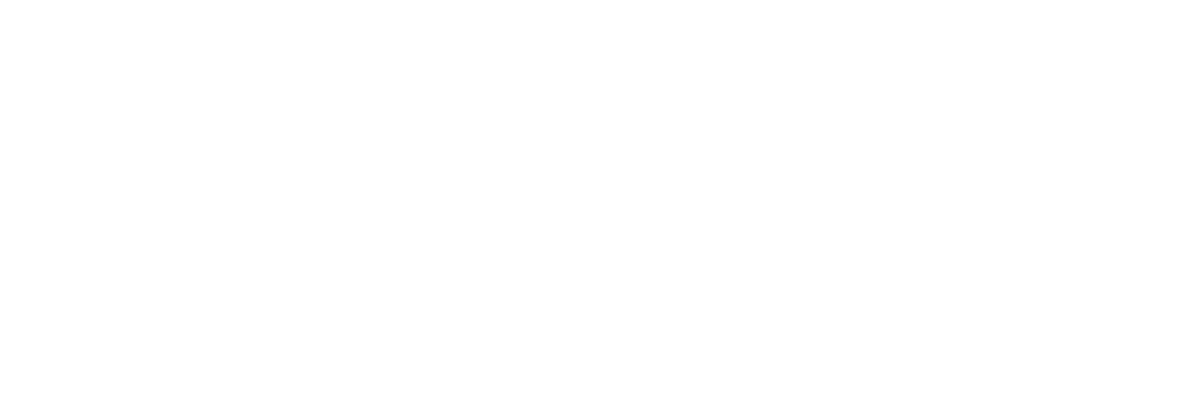

<IPython.core.display.Javascript object>


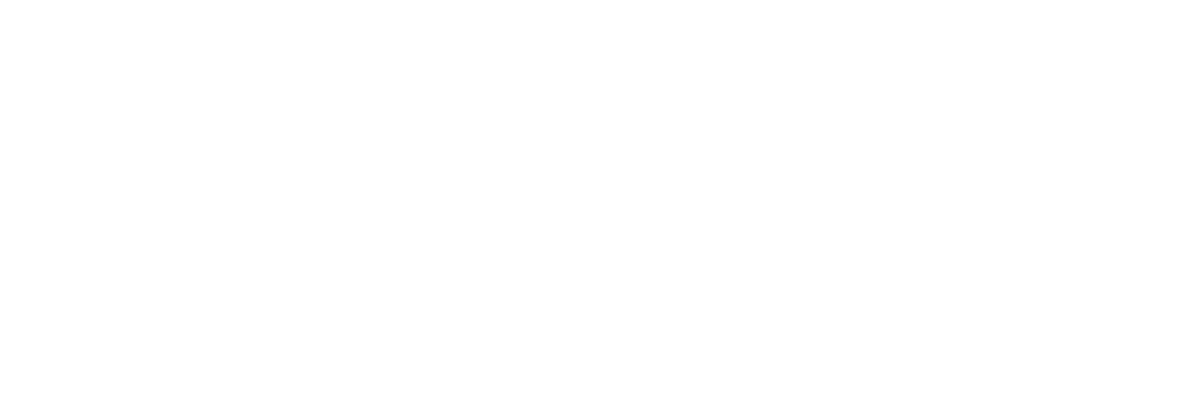

<IPython.core.display.Javascript object>


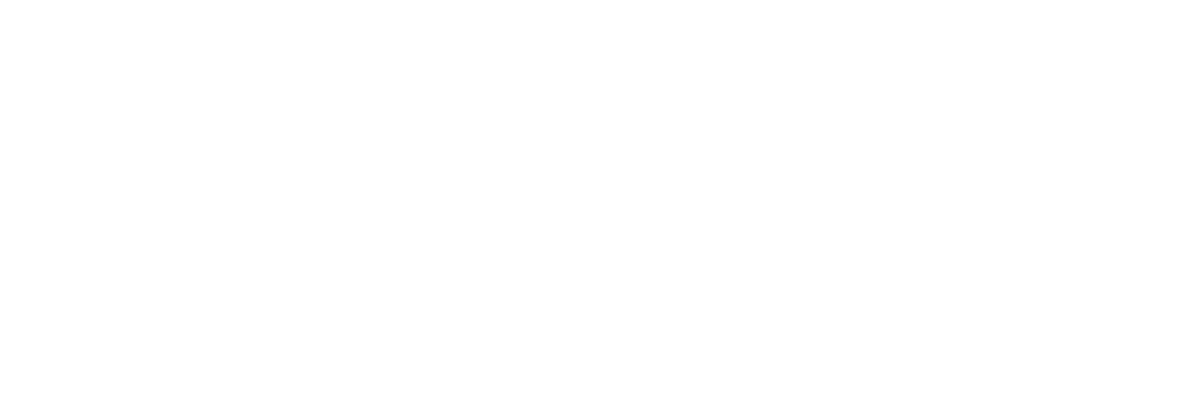

In [9]:

k= list(STREAMS.keys())[0]
filename='simpler_rgc10_direct_nbody1.00e+06*'
f=path_data+'/{}.npy'.format(filename)
filenames=np.array(glob.glob(f))
st0=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
STREAMS[k]= st0
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(st0.x, st0.y, s=1)

#if False:
k= list(STREAMS.keys())[1]
filename='simpler_rgc30_direct_nbody1.00e+06*'
f=path_data+'/{}.npy'.format(filename)
filenames=np.array(glob.glob(f))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
STREAMS[k]= st0
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(st.x, st.y, s=1)

k= list(STREAMS.keys())[-1]
filename='simpler_rgc50_direct_nbody1.00e+06*'
f=path_data+'/{}.npy'.format(filename)
filenames=np.array(glob.glob(f))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
STREAMS[k]= st0
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(st.x, st.y, s=1)




In [10]:
GAP_CENTERS={'10_20': (5, 4),
            '30_40': (5, 4),
            '50_60':(5, 4)}

In [11]:
%matplotlib inline

In [12]:

dmod=24.43
d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
d_M31

0.7691304402866098

nstars 198
nstars 198
nstars 198
nstars 1083
nstars 1081
nstars 1081


/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_42836/1923710376.py:59: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path_plot+'/gaps_at_M31.jpeg'.format(mag_limit), rasterized=True)


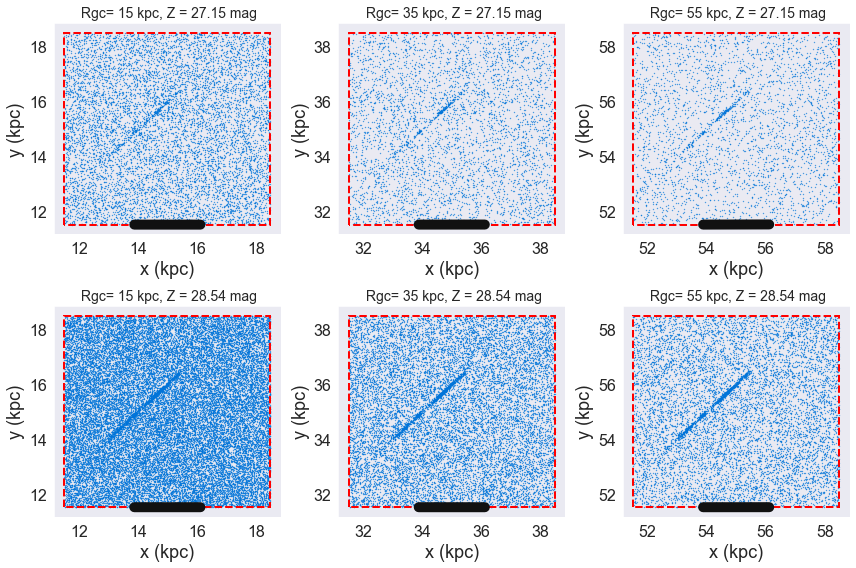

In [13]:
images={}

fig, ax=plt.subplots(figsize=(12, 4*2), ncols=3, nrows=2)

for  idx in range(0, 6):
    
    a= np.concatenate(ax)[idx]
    dist= dist_arr[idx]
    mag_limit=mag_limits[idx]
    #get backgrounds
    
    rgc=np.nanmedian(np.array(dist.split('_')).astype(float))
    
    center=np.array([0, 0 ])+rgc
    
    vals=get_background(center, dist_range=dist, dmod=dmod, FeH_phot=-1., mag_limit=mag_limit)
    
    scaled_arcmin= vals['arcmin']
    
    

    a.plot((center[0]-scaled_arcmin.value/2, center[0]+scaled_arcmin.value/2),
           (vals['data'].x_coord.min(), vals['data'].y_coord.min()), lw=10, c='#111111', linestyle='-')
    
    b=vals['box']
    b.alpha=1.
    b.plot(ax=a)
    
    d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
    
    a.scatter(vals['data'].x_coord, vals['data'].y_coord, s=0.1, color='#0074D9')
    
    evolved_st= STREAMS[dist]
    
    #gap_center=(np.nanmedian( evolved_st.y.value), np.nanmedian(evolved_st.x.value))
    gap_center=GAP_CENTERS[dist]
    
    rst= resample_stream([evolved_st.x.value, evolved_st.y.value], \
                         mag_limits[idx], dmod, gap_center, vals['box'].center, vals['box'])
    a.scatter(rst[0], rst[1],  s=0.1, color='#0074D9')
    
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.set_title(' Rgc= {:.0f} kpc, Z = {} mag'.format(rgc, mag_limit), fontsize=14)
    a.set_xlabel('x (kpc)', fontsize=18)
    a.set_ylabel('y (kpc)', fontsize=18)
    
    print ('nstars {}'.format(len(rst[0])))
    

    
    #append values to one image
    images.update({'{} mlimit {}'.format(dist, mag_limits[idx]): [np.concatenate([vals['data'].x_coord,rst[0]]), \
                                           np.concatenate([vals['data'].y_coord,rst[1]])]})
    

plt.tight_layout()


plt.savefig(path_plot+'/gaps_at_M31.jpeg'.format(mag_limit), rasterized=True)


In [14]:
#iimplement a a KL divergence to measure how different the 
from scipy.signal import find_peaks
def kernel_density(x, bw_method=0.01):
    return stats.gaussian_kde(x, bw_method= bw_method)


def return_estimated_2d_kernel(x, y, bw_method=0.1, xmin=0, xmax=0, ymin=0, ymax=0):
    values = np.vstack([x, y])
    k=kernel_density(values, bw_method=bw_method)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    grid = np.vstack([X.ravel(), Y.ravel()])
    kde=k(grid)
    Z = np.reshape(kde.T, X.shape)
    return { 'grid': grid, 'kde':Z}


def return_estimated_1d_kernel(x,bw_method=0.1, xmin=0, xmax=0):
    k=kernel_density(x, bw_method=bw_method)
    grid = np.linspace(xmin, xmax, 5000)
    kde=k(grid)
    return { 'grid': grid, 'kde':kde, 'estimator': k}

def compute_kl_divergence(p, q):
    return np.nansum(p*np.log(p/q))


def estimate_kl_divergence_iterative(x, bws=[0.1, 0.6], search_region=None):
    
    if search_region is None:
        search_region=[x.min(), x.max()]
    
    #1-d KL divergence iterative
    #alernative: march through the grid of points to see which ones are the closest to 1
    X0=return_estimated_1d_kernel(x,bw_method=bws[0], xmin=search_region[0], xmax=search_region[1])
    X1=return_estimated_1d_kernel(x,bw_method=bws[-1], xmin=search_region[0], xmax=search_region[1])
    
    n_chunks=len(X1['kde'])
    x0=X0['kde']
    x1=X1['kde']
    r=np.exp(-(x0-x1)**2)
    kl_sub_array=[]
    chunks=np.array_split(r, n_chunks)
    
    for chunck in chunks:
        kl_sub_array.append(compute_kl_divergence(chunck, np.ones_like(chunck)))
    return  X1['grid'],  np.array(kl_sub_array)

def estimate_kde_ratios(x, bws=[0.1, 0.6], search_region=None):
    if search_region is None:
        search_region=[x.min(), x.max()]
    
    #1-d KL divergence iterative
    #alernative: march through the grid of points to see which ones are the closest to 1
    X0=return_estimated_1d_kernel(x,bw_method=bws[0], xmin=search_region[0], xmax=search_region[1])
    X1=return_estimated_1d_kernel(x,bw_method=bws[-1], xmin=search_region[0], xmax=search_region[1])
    kderatio=X1['kde']/X0['kde']
    return [X1['grid'], kderatio], [X0['kde'], X1['kde']]

def add_fake_stars_center(xy, cent, nstars=100, radius=0.1):
    
    mask= (np.abs(xy[0]-center[0])**2+np.abs(xy[1]-center[1])**2)<radius**2
    print (mask.all())
    
    xdraw= np.random.uniform(xy[0][mask].min(), xy[0][mask].max(), int(nstars) )
    ydraw= np.random.uniform(xy[1][mask].min(), xy[1][mask].max(), int(nstars) )
    
    return [np.concatenate([xy[0], xdraw]), np.concatenate([xy[1], ydraw])]
    #return xy[0][mask], xy[1][mask]

In [16]:
images.keys()

dict_keys(['10_20 mlimit 27.15', '30_40 mlimit 27.15', '50_60 mlimit 27.15', '10_20 mlimit 28.54', '30_40 mlimit 28.54', '50_60 mlimit 28.54'])

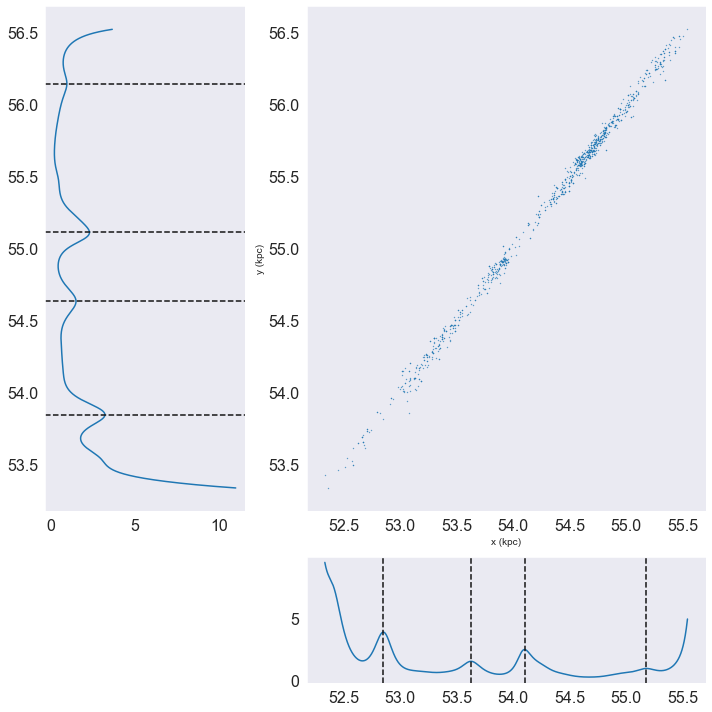

In [17]:
peaks_all={}
prominences={}
#use kde ratios 
k=list(images.keys())[0]
#k
#get the data
data=rst
#add fake stars at the center


#peaks_all.update({k: peaks})
#prominences.update({k: res})


fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[4, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
#ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3], sharex=ax2)


#ax.set(yscale='log')

#ax.plot( kl[0][peaks], kl[-1][peaks], "ob")


kl, dens=estimate_kde_ratios(data[1], bws=[0.1, 2])
peaks, res = find_peaks(kl[-1], prominence=0.0) 

ax1.plot( kl[1], kl[0])
for p in  kl[0][peaks]:
    ax1.axhline(p, linestyle='--', color='#111111')


kl, dens=estimate_kde_ratios(data[0], bws=[0.1, 2])
peaks, res = find_peaks(kl[-1], prominence=0.0) 

ax4.plot( kl[0], kl[1])
for p in  kl[0][peaks]:
    ax4.axvline(p, linestyle='--', color='#111111')
    

#ax.set(xlabel= 'x (kpc)', ylabel='Denstity ratio')

#    ax.axvline(p, linestyle='--', color='#111111')

ax2.scatter(data[0], data[1], s=0.1)
#ax2.scatter(prog.y.value[0], prog.x.value[0], s=100)
ax2.set(xlabel='x (kpc)', ylabel='y (kpc)')
cent= np.nanmean(data, axis=1)



#d=add_fake_stars_center(data, [cent[0]-0.15, cent[1]-0.15], nstars=100, radius=1.4)

#ax2.scatter(d[0], d[1], s=1)
#ax2.scatter(cent[0]-0.15, cent[1]-0.15, s=100)

plt.tight_layout()

In [18]:
#f= path_data+'test_addmore.npy*'
#filenames=np.array(glob.glob(f))
#st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
#prog_more=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['prog']
#rst_more=[st.y.value, st.z.value]

In [19]:
#fig, ax=plt.subplots(figsize=(12, 4))
#ax.scatter(rst[0], rst[1], s=5, alpha=0.2)
#ax.scatter(rst_more[0], rst_more[1]+1., s=5, alpha=0.2)
#ax.scatter(prog_more.y.value[0], prog_more.z.value[0]+1., s=100, c='k')
#ax.scatter(prog.y.value[0], prog.z.value[0], s=100, c='k')
#ax.set(xlim=[-3, 3], ylim=[-4, 5])


In [20]:
rst_more=rst

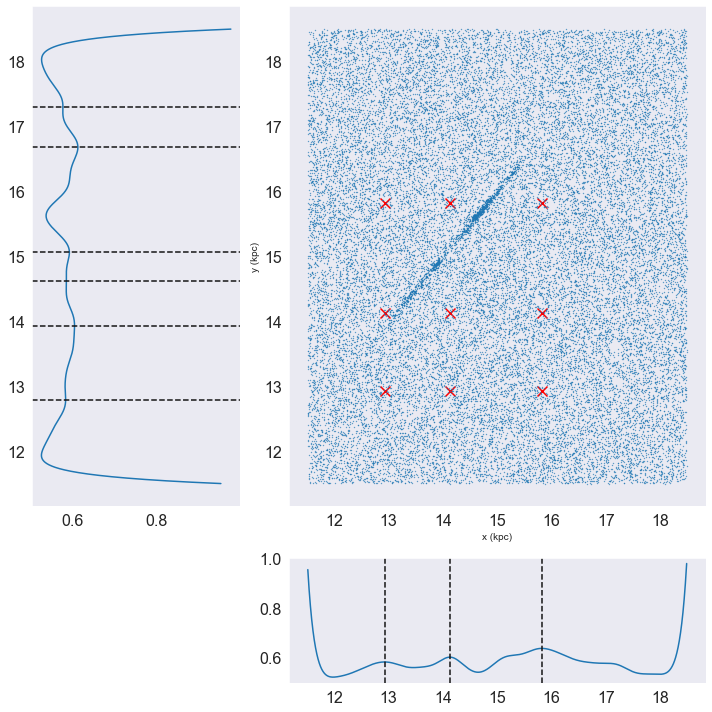

In [21]:
peaks_all={}
prominences={}
#use kde ratios 
k='10_20 mlimit 28.54'
#k
#get the data
data=images[k]
#add fake stars at the center


#peaks_all.update({k: peaks})
#prominences.update({k: res})


fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[4, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
#ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3], sharex=ax2)


#ax.set(yscale='log')

#ax.plot( kl[0][peaks], kl[-1][peaks], "ob")


kl, dens=estimate_kde_ratios(data[1], bws=[0.1, 2])
peaks, res = find_peaks(kl[-1], prominence=0.0) 

ax1.plot( kl[1], kl[0])
for p in  kl[0][peaks]:
    ax1.axhline(p, linestyle='--', color='#111111')


kl, dens=estimate_kde_ratios(data[0], bws=[0.1, 2])
peaks, res = find_peaks(kl[-1], prominence=0.0) 

ax4.plot( kl[0], kl[1])
for p in  kl[0][peaks]:
    ax4.axvline(p, linestyle='--', color='#111111')

for px in  kl[0][peaks]:
    for  py in  kl[0][peaks]:
        #find which x is y and which y is x
        #ax2.scatter(px, data[1][np.logical_and(data[0]>=px-buffer,  data[0]<px+buffer)][-1], s=100, \
        #            marker='x', c='b')
        ax2.scatter(px,py, s=100, marker='x', c='r')

#ax.set(xlabel= 'x (kpc)', ylabel='Denstity ratio')

#    ax.axvline(p, linestyle='--', color='#111111')

ax2.scatter(data[0], data[1], s=0.1)
#ax2.scatter(prog.y.value[0], prog.x.value[0], s=100)
ax2.set(xlabel='x (kpc)', ylabel='y (kpc)')
cent= np.nanmean(data, axis=1)



#d=add_fake_stars_center(data, [cent[0]-0.15, cent[1]-0.15], nstars=100, radius=1.4)

#ax2.scatter(d[0], d[1], s=1)
#ax2.scatter(cent[0]-0.15, cent[1]-0.15, s=100)

plt.tight_layout()

In [22]:

#f= path_data+'test.npy*'
#filenames=np.array(glob.glob(f))
#st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
#prog=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['prog']
#rst=[st.y.value, st.z.value]

#f= path_data+'test_addmore.npy*'
#filenames=np.array(glob.glob(f))
#st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
#prog_more=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['prog']
#rst_more=[st.y.value, st.z.value]

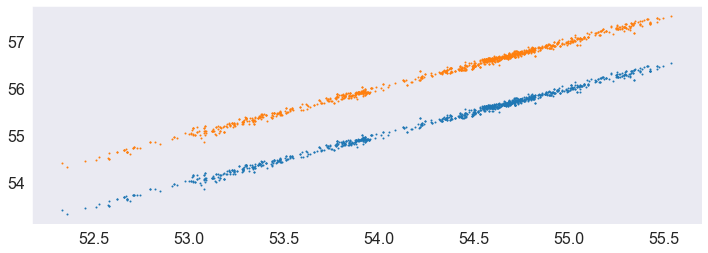

In [23]:
fig,ax=plt.subplots(figsize=(12., 4))
ax.scatter(rst[0], rst[1], s=1)
ax.scatter(rst_more[0], rst_more[1]+1., s=1.)
#ax.scatter(prog[0].y.value, prog[0].z.value, s=100, color='k' )
#ax.scatter(prog_more[0].y.value, prog_more[0].z.value+1., s=100, color='k' )

In [24]:
from findthegap.gapper import Gapper
from sklearn.preprocessing import StandardScaler

In [25]:
data_old=np.vstack(images[k]).T

In [26]:
len(rst_more[0])

1081

In [35]:
#scaler = StandardScaler()
#scaler.fit(data_old)
#data = scaler.transform(data_old)
data=data_old #don't fit mix max with sklearn
# Boundaries for the Gapper (if none are provided, this is the datadefault mode)
bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])


bw =5
gridding_size = 32

gapper_base = Gapper(data, bw, bounds)

In [ ]:

grid_data, grid_density = gapper_base.compute_density_grid(gridding_size = gridding_size)

density_matr = grid_density.reshape((gridding_size, gridding_size))


In [ ]:
grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size) for d in range(data.shape[1]) ]
meshgrid = np.array(np.meshgrid(*grid_linspace, indexing='ij'))

In [ ]:
#compute critical points 
critical_points = gapper_base.compute_all_critical_points()
#eigen values
eig_vals_H = np.array([np.linalg.eigh(gapper_base.get_Hessian(pt))[0] for pt in grid_data])

max_eig_vals_H_grid = np.max(eig_vals_H, axis=1).reshape((gridding_size, gridding_size))

In [ ]:
N = 50
H_eigval_crits = []

for pts in critical_points:
    eig_val_H, eig_vec_H, logd_apoint, g, H = gapper_base.get_g_H_eigvH(pts)
    H_eigval_crits.append(eig_val_H)

H_eigval_crits = np.array(H_eigval_crits)


max_eigval_H = np.max(H_eigval_crits, axis=1)
idx_best_crits  = np.argsort(max_eigval_H)[::-1][:N]

In [ ]:
index_count_eigvalH = np.sum(H_eigval_crits < 0 , axis=1) 

In [ ]:
fig, (ax, ax1, ax2)=plt.subplots(figsize=(14, 6), ncols=3, sharex=True, sharey=True)

mp=ax1.contourf(meshgrid[0], meshgrid[1], max_eig_vals_H_grid, 20, cmap='RdBu_r',
             vmin = -(np.max(np.abs(max_eig_vals_H_grid))), vmax=np.max(np.abs(max_eig_vals_H_grid)))

#cb = plt.colorbar(mp, label="Maximum eigenvalue of the Hessian $\mathbf{H}$")

#norm= mpl.colors.Normalize(vmin=0,vmax=13)
#mp=mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cax = fig.add_axes([1.01, 0.1, .015, 0.85])
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r"Maximum eigenvalue of the Hessian $\mathbf{H}$", fontsize=18)
plt.tight_layout()
ax.scatter(images[k][0] , images[k][1], s=1)
ax1.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap='copper', alpha=.5)


critsc =ax1.scatter(critical_points[idx_best_crits][:,0], critical_points[idx_best_crits][:,1], 
                     s=80, c="None", edgecolor='k', label='{} best critical points'.format(N))

plt.legend()

cax = fig.add_axes([1.1, 0.1, .015, 0.85])
ctf = ax2.contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap='cubehelix')
cb = plt.colorbar(ctf, cax=cax)
cb.ax.set_ylabel(r'Density Estimate ', fontsize=18)


for a in [ax, ax1,ax2]:
    a.set_xlabel('x (kpc)', fontsize=18)
    a.set_ylabel('y (kpc)', fontsize=18)
    a.minorticks_on()
plt.tight_layout()
plt.savefig(path_plot+'/example_detection.jpeg', bbox_inches='tight')


In [ ]:
#must 